<a href="https://colab.research.google.com/github/Dollie1330/DAA-LAB-4-airline-crew-scheduling-backtracking/blob/main/DAA_LAB_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install memory-profiler --quiet

import itertools
import time
import random
import tracemalloc
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict


In [2]:
# Example flights: (id, start_hour, end_hour)
flights = [
    ('F1', 9, 11),
    ('F2', 10, 12),
    ('F3', 13, 15),
    ('F4', 11, 12),
    ('F5', 15, 17)
]

crew_members = ['C1', 'C2', 'C3']   # crew list
MIN_REST = 1   # minimum rest hours


In [3]:
def flights_conflict(f1: Tuple[str,int,int], f2: Tuple[str,int,int], min_rest: int) -> bool:
    _, s1, e1 = f1
    _, s2, e2 = f2

    # Overlap check
    if not (e1 <= s2 or e2 <= s1):
        return True

    # Rest time check
    if e1 <= s2 and (s2 - e1) < min_rest:
        return True
    if e2 <= s1 and (s1 - e2) < min_rest:
        return True

    return False


def can_assign_to_crew(crew_schedule: List[Tuple[str,int,int]], flight: Tuple[str,int,int], min_rest: int) -> bool:
    for f in crew_schedule:
        if flights_conflict(f, flight, min_rest):
            return False
    return True


In [4]:
def assign_flights_backtracking(flights, crew_members, min_rest, stop_at_first=True):
    flights_sorted = sorted(flights, key=lambda x: x[1])
    n = len(flights_sorted)
    k = len(crew_members)

    schedule = [[] for _ in range(k)]
    solutions = []
    recursive_calls = 0

    def backtrack(i):
        nonlocal recursive_calls
        recursive_calls += 1

        if i == n:
            sol = {crew_members[j]: [f[0] for f in schedule[j]] for j in range(k)}
            solutions.append((sol, [list(s) for s in schedule]))
            return True

        flight = flights_sorted[i]

        for j in range(k):
            if can_assign_to_crew(schedule[j], flight, min_rest):
                schedule[j].append(flight)
                res = backtrack(i + 1)
                if res and stop_at_first:
                    return True
                schedule[j].pop()

        return False

    start = time.time()
    backtrack(0)
    end = time.time()

    return {
        "solutions": solutions,
        "recursive_calls": recursive_calls,
        "time": end - start,
        "sorted_flights": flights_sorted
    }


In [5]:
result = assign_flights_backtracking(flights, crew_members, MIN_REST, stop_at_first=True)

print("Execution Time:", result["time"])
print("Recursive Calls:", result["recursive_calls"])

if result["solutions"]:
    sol_map, schedules = result["solutions"][0]
    print("\nAssignment:")
    print(sol_map)

    print("\nDetailed Schedule:")
    for i, crew in enumerate(crew_members):
        print(crew, "->", [ (f[0], f[1], f[2]) for f in schedules[i] ])
else:
    print("No valid assignment found.")


Execution Time: 2.4557113647460938e-05
Recursive Calls: 6

Assignment:
{'C1': ['F1', 'F3'], 'C2': ['F2', 'F5'], 'C3': ['F4']}

Detailed Schedule:
C1 -> [('F1', 9, 11), ('F3', 13, 15)]
C2 -> [('F2', 10, 12), ('F5', 15, 17)]
C3 -> [('F4', 11, 12)]


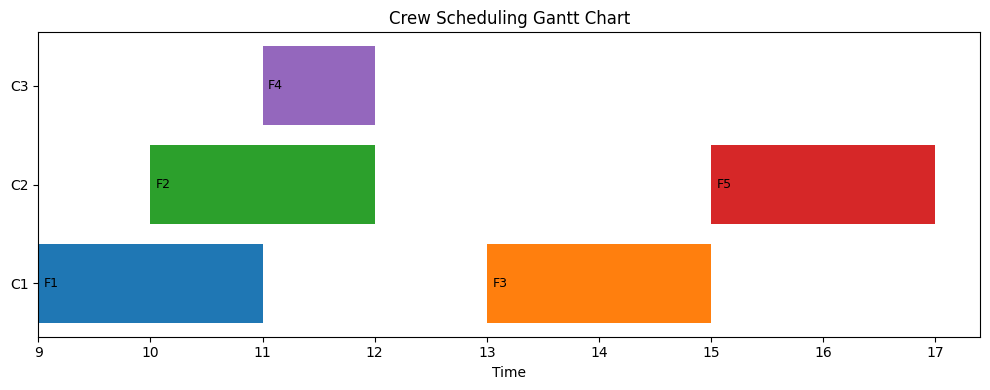

In [6]:
def plot_gantt(schedules, crew_labels):
    fig, ax = plt.subplots(figsize=(10, 1 + len(schedules)))
    yticks = []
    yticklabels = []

    for i, crew_sched in enumerate(schedules):
        y = i
        for f in crew_sched:
            fid, s, e = f
            ax.barh(y, e - s, left=s)
            ax.text(s + 0.05, y, fid, va='center', fontsize=9)

        yticks.append(y)
        yticklabels.append(crew_labels[i])

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel("Time")
    ax.set_title("Crew Scheduling Gantt Chart")
    plt.tight_layout()
    plt.show()


if result["solutions"]:
    _, schedules = result["solutions"][0]
    plot_gantt(schedules, crew_members)


n=4 → avg time=0.0000s, avg calls=7.2
n=5 → avg time=0.0000s, avg calls=8.0
n=6 → avg time=0.0000s, avg calls=7.0
n=7 → avg time=0.0001s, avg calls=49.2
n=8 → avg time=0.0001s, avg calls=53.0
n=9 → avg time=0.0002s, avg calls=113.2
n=10 → avg time=0.0000s, avg calls=24.0


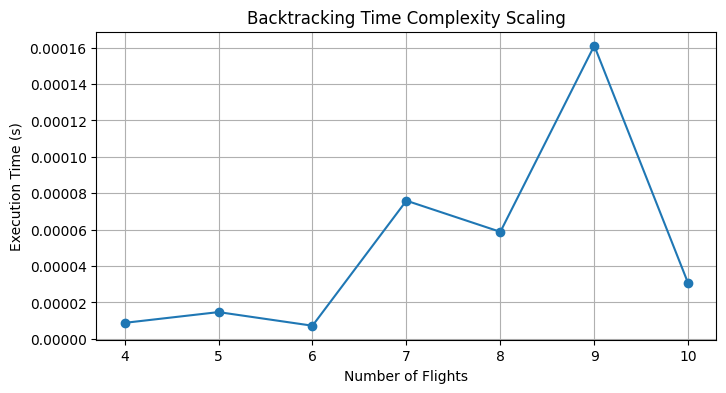

In [7]:
import statistics

def random_flights(n, start_window=(6,18), min_dur=1, max_dur=3):
    flights = []
    for i in range(n):
        s = random.randint(start_window[0], start_window[1])
        dur = random.randint(min_dur, max_dur)
        flights.append((f"F{i+1}", s, s + dur))
    return flights


def scaling_experiment(trials=5, crew_k=3, min_rest=1, n_values=range(4,11)):
    times = {}
    calls = {}

    for n in n_values:
        t_list, c_list = [], []
        for _ in range(trials):
            fls = random_flights(n)
            res = assign_flights_backtracking(fls, [f"C{i+1}" for i in range(crew_k)], min_rest)
            t_list.append(res["time"])
            c_list.append(res["recursive_calls"])

        times[n] = statistics.mean(t_list)
        calls[n] = statistics.mean(c_list)
        print(f"n={n} → avg time={times[n]:.4f}s, avg calls={calls[n]:.1f}")

    return times, calls


times, calls = scaling_experiment()

# Plot Time vs Flights
plt.figure(figsize=(8,4))
plt.plot(list(times.keys()), list(times.values()), marker='o')
plt.grid(True)
plt.xlabel("Number of Flights")
plt.ylabel("Execution Time (s)")
plt.title("Backtracking Time Complexity Scaling")
plt.show()
